In [1]:
import comet_ml

# Initializing the project
comet_ml.init(project_name="text-classification-with-transformers")

In [2]:
from huggingface_hub import notebook_login

# Logining Hugging Face
notebook_login()

In [3]:
from datasets import load_dataset

# Loading the dataset
raw_datasets = load_dataset("rotten_tomatoes")

In [4]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [5]:
# Looking at the first sample of the training set
raw_datasets["train"][0]

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
 'label': 1}

In [6]:
import pandas as pd

# Converting the dataset into Pandas dataframe
raw_datasets.set_format(type="pandas")
df = raw_datasets["train"][:]
df.head()

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


In [7]:
df.shape

(8530, 2)

In [8]:
df['label'].value_counts()

label
1    4265
0    4265
Name: count, dtype: int64

In [9]:
df.columns

Index(['text', 'label'], dtype='object')

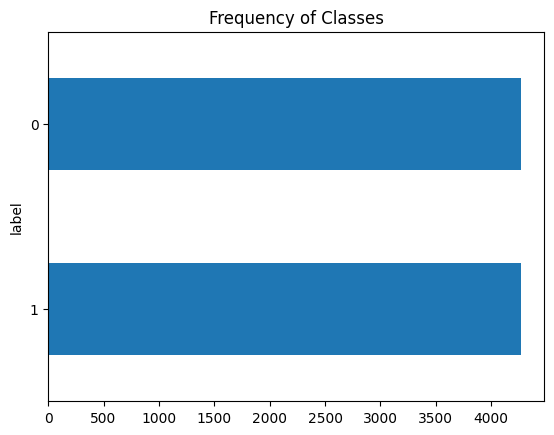

In [10]:
import matplotlib.pyplot as plt

# Visualizing the frequency of classes
df["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

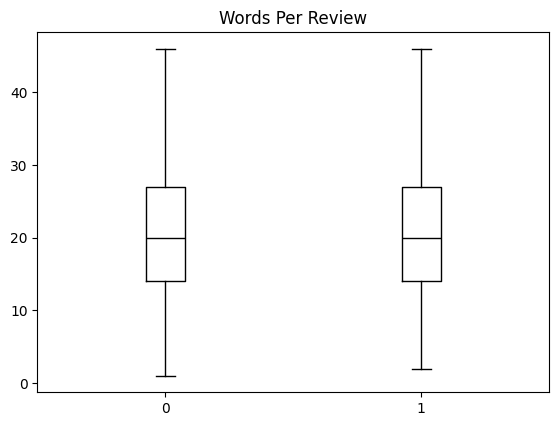

In [11]:
# Visualizing words per review
df["Words Per Review"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Review", by="label", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [12]:
# Reseting the dataset format
raw_datasets.reset_format()

## Preprocessing

In [13]:
from transformers import AutoTokenizer

# Loading the DistilBERT tokenizer 
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [14]:
# Creating a function for tokenization
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

# Applying the function to the entire dataset
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [15]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1066
    })
})

In [16]:
from transformers import DataCollatorWithPadding

# Padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Evaluation


In [17]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Indexing to example function
def get_example(index):
    return tokenized_datasets["test"][index]["text"]

# Creating a function to compute metrics
def compute_metrics(pred):
    experiment = comet_ml.get_global_experiment()

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro"
    )
    acc = accuracy_score(labels, preds)

    if experiment:
        epoch = int(experiment.curr_epoch) if experiment.curr_epoch is not None else 0
        experiment.set_epoch(epoch)
        experiment.log_confusion_matrix(
            y_true=labels,
            y_predicted=preds,
            file_name=f"confusion-matrix-epoch-{epoch}.json",
            labels=["negative", "positive"],
            index_to_example_function=get_example,
        )

    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

## Transformers

In [18]:
from transformers import AutoModelForSequenceClassification

# Mapping ids to labels 
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

# Building the model
model = AutoModelForSequenceClassification.from_pretrained(
              checkpoint, num_labels=2, id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
from transformers import TrainingArguments, Trainer

# Setting Comet enviroment variables
%env COMET_MODE=ONLINE
%env COMET_LOG_ASSETS=TRUE

# Setting training arguments
training_args = TrainingArguments(
    output_dir="my_distilbert_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
    report_to=["comet_ml"],
)

# Creating a trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

# Training the model
trainer.train()

env: COMET_MODE=ONLINE
env: COMET_LOG_ASSETS=TRUE


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'c:\\Users\\zzaib\\Desktop\\vs-code-projects\\bert-text-classification-gradio' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/qaicodes/text-classification-with-transformers/a9fb014385b449988404365af795e52b



  0%|          | 0/1602 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.4172, 'learning_rate': 1.3757802746566792e-05, 'epoch': 0.94}


  0%|          | 0/67 [00:00<?, ?it/s]

{'eval_loss': 0.42757463455200195, 'eval_accuracy': 0.8133208255159474, 'eval_f1': 0.8113484070343937, 'eval_precision': 0.826996267560101, 'eval_recall': 0.8133208255159474, 'eval_runtime': 56.5077, 'eval_samples_per_second': 18.865, 'eval_steps_per_second': 1.186, 'epoch': 1.0}
{'loss': 0.2485, 'learning_rate': 7.515605493133583e-06, 'epoch': 1.87}


  0%|          | 0/67 [00:00<?, ?it/s]

{'eval_loss': 0.45702797174453735, 'eval_accuracy': 0.8414634146341463, 'eval_f1': 0.8414521132648347, 'eval_precision': 0.8415608011041942, 'eval_recall': 0.8414634146341463, 'eval_runtime': 59.0768, 'eval_samples_per_second': 18.044, 'eval_steps_per_second': 1.134, 'epoch': 2.0}
{'loss': 0.1602, 'learning_rate': 1.2734082397003748e-06, 'epoch': 2.81}


  0%|          | 0/67 [00:00<?, ?it/s]

{'eval_loss': 0.5490453243255615, 'eval_accuracy': 0.8377110694183865, 'eval_f1': 0.8376995005610437, 'eval_precision': 0.8378073857074448, 'eval_recall': 0.8377110694183865, 'eval_runtime': 54.6017, 'eval_samples_per_second': 19.523, 'eval_steps_per_second': 1.227, 'epoch': 3.0}
{'train_runtime': 5435.3229, 'train_samples_per_second': 4.708, 'train_steps_per_second': 0.295, 'train_loss': 0.2664589768789532, 'epoch': 3.0}


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/qaicodes/text-classification-with-transformers/a9fb014385b449988404365af795e52b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch [7]                   : (0.94, 3.0)
COMET INFO:     eval_accuracy [3]           : (0.8133208255159474, 0.8414634146341463)
COMET INFO:     eval_f1 [3]                 : (0.8113484070343937, 0.8414521132648347)
COMET INFO:     eval_loss [3]               : (0.42757463455200195, 0.5490453243255615)
COMET INFO:     eval_precision [3]          : (0.826996267560101, 0.8415608011041942)
COMET INFO:     eval_recall [3]             : (0.8133208255159474, 0.8414634146341463)
COMET INFO:     eval_

TrainOutput(global_step=1602, training_loss=0.2664589768789532, metrics={'train_runtime': 5435.3229, 'train_samples_per_second': 4.708, 'train_steps_per_second': 0.295, 'train_loss': 0.2664589768789532, 'epoch': 3.0})

In [20]:
# Pushing the model
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/zzaibis/my_distilbert_model/commit/693a5550f48fcae3c85ad2f6756afdebb1446e60', commit_message='End of training', commit_description='', oid='693a5550f48fcae3c85ad2f6756afdebb1446e60', pr_url=None, pr_revision=None, pr_num=None)

In [25]:
tokenizer.push_to_hub("qaicodes/my_distilbert_model")

CommitInfo(commit_url='https://huggingface.co/qaicodes/my_distilbert_model/commit/fe9abc2291937af4b60c3d630f1643077d9be84f', commit_message='Upload tokenizer', commit_description='', oid='fe9abc2291937af4b60c3d630f1643077d9be84f', pr_url=None, pr_revision=None, pr_num=None)

In [26]:
from transformers import pipeline

# Creating a text
text = "This is a great movie. It may be my favourite."

# Predicting the label
classifier = pipeline("sentiment-analysis", 
                       model="qaicodes/my_distilbert_model")
classifier(text)

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

c:\Users\zzaib\Desktop\vs-code-projects\bert-text-classification-gradio\.venv\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\zzaib\.cache\huggingface\hub\models--qaicodes--my_distilbert_model. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9611639976501465}]

In [ ]:
import gradio as gr
from transformers import pipeline

# Creating pipeline
classifier = pipeline("sentiment-analysis", 
                      model="qaicodes/my_distilbert_model")

# Creating a function for text classification
def text_classification(text):
    result= classifier(text)
    sentiment_label = result[0]['label']
    sentiment_score = result[0]['score']
    formatted_output = f"This sentiment is {sentiment_label} with the probability {sentiment_score*100:.2f}%"
    return formatted_output

# Getting examples 
examples=["This is wonderful movie!", "The movie was really bad; I didn't like it."]

# Building a Gradio interface
io = gr.Interface(fn=text_classification, 
                         inputs= gr.Textbox(lines=2, label="Text", placeholder="Enter title here..."), 
                         outputs=gr.Textbox(lines=2, label="Text Classification Result"),
                         title="Text Classification",
                         description="Enter a text and see the text classification result!",
                         examples=examples)

io.launch(inline=False, share=True)

# Logging the app to the Comet Dashboard
experiment = comet_ml.Experiment()
experiment.add_tag("text-classifier")

# Integrating Comet
io.integrate(comet_ml=experiment)